In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
sns.set()
MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
J_DAYS = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
CITIES = ['מודיעין מכבים רעות', 'באר שבע', 'נתניה']
MODIIN,BEERSHEVA,NETANIA = CITIES

In [2]:
#full_df = pd.read_pickle('full.pkl')
full_hour_df = pd.read_pickle('hour.pkl')
full_day_df = pd.read_pickle('day.pkl')
id_df = pd.read_pickle('id.pkl')

In [3]:
full_hour_df = full_hour_df[full_hour_df.year == 2022]
full_hour_df.head(1)

,total,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,hour,consumption,ts,temperature,r_humidity,heat_index
0,199.341003,702552276,11,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,0,5.037,2022-01-01,10.716666,79.5,10.716667


In [4]:
full_day_df = full_day_df.rename(columns={'total':'consumption'})
full_day_df = full_day_df[(full_day_df.year == 2022) & (full_day_df.city == MODIIN)]
full_day_df.head(1)

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts
0,702552276,11,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,199.341003,9.863194,84.395836,9.863194,2022-01-01


In [5]:
id_df.head(1)

,count_reg,no.,city,city_code_HHI,city_code_LAMAS,street,address,lat,lng
id,,,,,,,,,
702552276,11,32,מודיעין מכבים רעות,1932,1200,חרצית,חרצית 32 מודיעין מכבים רעות,31.905869,35.010933


In [6]:
full_day_df.id.nunique()

2572

## 2572 unique ids in Moddin in 2022

In [7]:
gr = full_day_df[(full_day_df.month >=4) & (full_day_df.month <=9)].groupby('id').count().reset_index()
not_full_period_ids = set(gr[gr.count_reg < 183].id)
len(not_full_period_ids)

237

## 237 without daily data in April - September (2335 left)

In [8]:
full_day_df = full_day_df[full_day_df.id.map(lambda x: x not in not_full_period_ids)]
full_day_df.id.nunique()

2335

In [9]:
area_df = pd.read_csv('./raw_data/modiin_join_flr_area.csv')
area_dict = area_df[['building_number', 'flr_area']].set_index('building_number').to_dict()['flr_area']
full_hour_df['area'] = full_hour_df.id.map(lambda x: area_dict.get(x, 0))
full_day_df['area'] = full_day_df.id.map(lambda x: area_dict.get(x, 0))
id_df['area'] = id_df.index.map(lambda x: area_dict.get(x, 0))

In [10]:
no_area_ids = set([x for x in full_day_df.id.unique() if x not in area_dict])
len(no_area_ids)

298

## 298 without area (2037 left)

In [11]:
full_day_df = full_day_df[full_day_df.area > 0]
full_day_df.id.nunique()

2037

In [12]:
tmp_df = pd.read_csv('./raw_data/modiin_data_clean.csv', usecols=['building_number'])
valid_ids = set(tmp_df.building_number.unique())
invalid_ids = [x for x in full_day_df.id.unique() if x not in valid_ids]
len(invalid_ids)

0

## 0 purely commercial according to Talia's moddin_data_clean.csv (2037 left)

In [13]:
full_day_df['consumption_per_sqm'] = full_day_df.consumption / full_day_df.area
full_day_df.head(1)

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts,area,consumption_per_sqm
0,702552276,11,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,199.341003,9.863194,84.395836,9.863194,2022-01-01,12027.25,0.016574


[(-2.0, 0.0)]

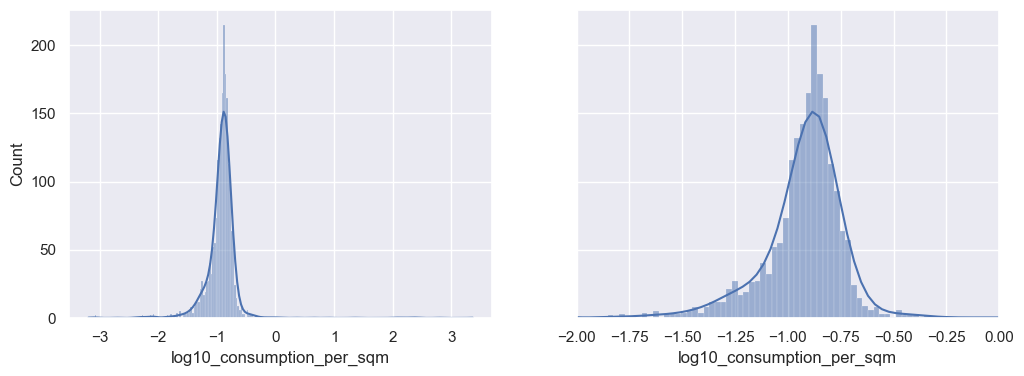

In [14]:
gr = full_day_df.groupby('id').mean(numeric_only=True).reset_index()
gr['log10_consumption_per_sqm'] = np.log10(gr.consumption_per_sqm)
_, ax = plt.subplots(1,2, sharey=True, figsize=(12,4))
sns.histplot(gr.log10_consumption_per_sqm, ax=ax[0], kde=True)
p = sns.histplot(gr.log10_consumption_per_sqm,  ax=ax[1], kde=True)
p.set(xlim=(-2, 0))

In [15]:
overconsuming = gr[gr.log10_consumption_per_sqm > -0.5].id.unique()
underconsuming = gr[gr.log10_consumption_per_sqm < -1.5].id.unique()
overconsuming_one_time = [x for x in full_day_df[full_day_df.consumption_per_sqm > 3].id.unique() if x not in overconsuming]
len(overconsuming), len(underconsuming), len(overconsuming_one_time)

(35, 43, 3)

## 35 overconsuming on avg (> 0.3 per sqm daily on avg). 
## 3 overconsuming one time (>3 per sqm at a single day)
## 43 underconsuming on avg (< 0.03 per sqm daily on avg)
## 1956 left

In [16]:
full_day_df = full_day_df[full_day_df.id.map(lambda x: x not in overconsuming and x not in underconsuming and x not in overconsuming_one_time)]
full_day_df.id.nunique()

1956

In [17]:
day_df = pd.DataFrame(full_day_df)
del full_day_df
day_df.head(1)

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts,area,consumption_per_sqm
872,702552305,49,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,1093.649048,9.863194,84.395836,9.863194,2022-01-01,12027.25,0.090931


In [18]:
ids = set(day_df.id.unique())
hour_df = pd.DataFrame(full_hour_df[(full_hour_df.id.map(lambda x: x in ids)) & (full_hour_df.year == 2022)])
del full_hour_df
hour_df['consumption_per_sqm'] = hour_df.consumption / hour_df.area
hour_df.head(1)

,total,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,hour,consumption,ts,temperature,r_humidity,heat_index,area,consumption_per_sqm
872,1093.649048,702552305,49,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,0,30.026001,2022-01-01,10.716666,79.5,10.716667,12027.25,0.002496


Text(0.5, 1.0, 'Hourly consumption per sqm')

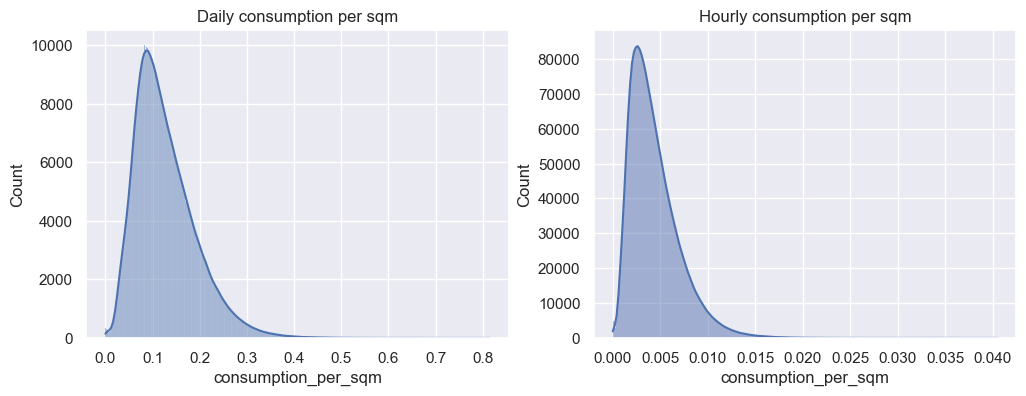

In [19]:
_, ax = plt.subplots(1,2, figsize=(12,4))
p = sns.histplot(day_df.consumption_per_sqm, ax=ax[0], kde=True)
p.set_title('Daily consumption per sqm')
p = sns.histplot(hour_df.consumption_per_sqm, ax=ax[1], kde=True)
p.set_title('Hourly consumption per sqm')

# Basic viz

In [28]:
def radar_plt(stats, ax, title, labels=None):
    if labels is None:
        labels = np.arange(1, len(stats)+1)
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)[::-1] # Set the angle
    stats=np.concatenate((stats,[stats[0]]))  # Closed
    angles=np.concatenate((angles,[angles[0]]))  # Closed
    ax.plot(angles, stats, 'o-', linewidth=2)  # Draw the plot (or the frame on the radar chart)
    ax.fill(angles, stats, alpha=0.25)  #Fulfill the area
    ax.set_thetagrids(angles * 180/np.pi, np.concatenate((labels, labels[:1])))  # Set the label for each axis
    ax.set_title(title)  # Set the pokemon's name as the title
    #ax.set_rlim(0,250)
    ax.grid(True)

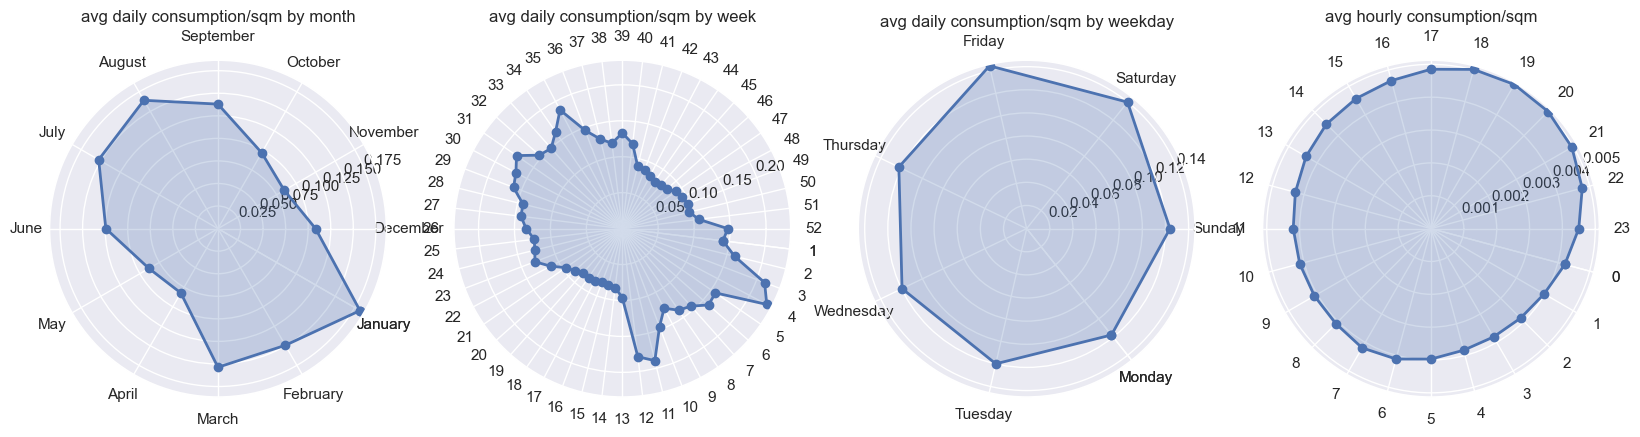

In [30]:
fig, axs = plt.subplots(figsize=(20, 5), nrows=1, ncols=4,
                            subplot_kw=dict(projection='polar'))
stats=day_df.groupby('month').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[0], 'avg daily consumption/sqm by month', MONTHS)
stats=day_df.groupby('week').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[1], 'avg daily consumption/sqm by week')
stats=day_df.groupby('weekday').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[2], 'avg daily consumption/sqm by weekday', DAYS)
stats=hour_df.groupby('hour').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[3], 'avg hourly consumption/sqm', np.arange(0,24))

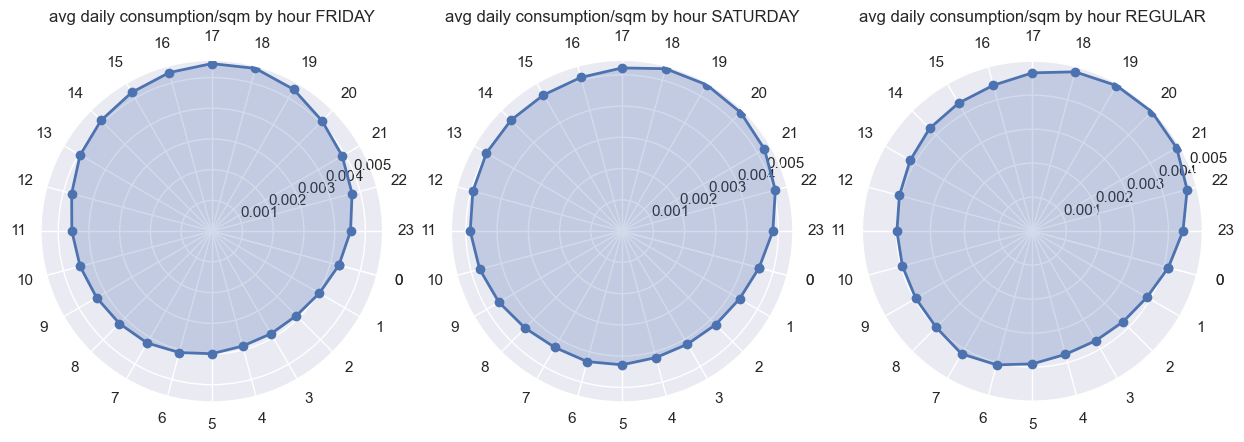

In [37]:
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3, subplot_kw=dict(projection='polar'))
city = MODIIN
stats=hour_df[(hour_df.weekday == 4)].groupby('hour').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[0], f'avg daily consumption/sqm by hour FRIDAY', np.arange(0,24))
stats=hour_df[(hour_df.weekday == 5)].groupby('hour').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[1], f'avg daily consumption/sqm by hour SATURDAY', np.arange(0,24))
stats=hour_df[(hour_df.weekday != 4) & (hour_df.weekday != 5)].groupby('hour').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[2], f'avg daily consumption/sqm by hour REGULAR', np.arange(0,24))

[Text(0.5, 1.0, 'consumption_per_sqm during the cold season')]

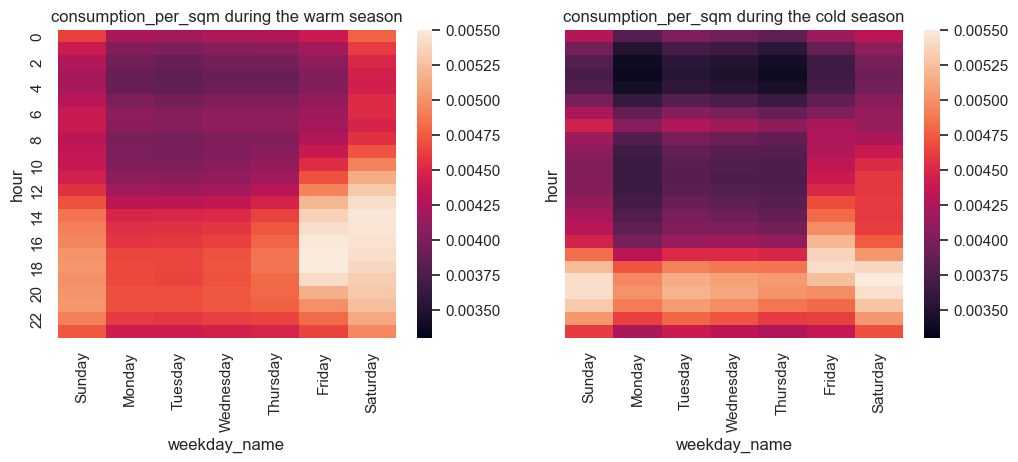

In [69]:
_, ax = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
table = hour_df[(hour_df.month >=4) & (hour_df.month <= 9)].groupby(['weekday_name', 'hour']).mean(numeric_only=True)['consumption_per_sqm'].reset_index().pivot(columns='weekday_name', index='hour', values='consumption_per_sqm')
p = sns.heatmap(table, ax=ax[0], vmin=0.0033, vmax=0.0055)
p.set(title='consumption_per_sqm during the warm season')
table = hour_df[(hour_df.month <4) | (hour_df.month > 9)].groupby(['weekday_name', 'hour']).mean(numeric_only=True)['consumption_per_sqm'].reset_index().pivot(columns='weekday_name', index='hour', values='consumption_per_sqm')
sns.heatmap(table, ax=ax[1], vmin=0.0033, vmax=0.0055).set(title='consumption_per_sqm during the cold season')

[Text(0.5, 1.0, 'consumption_per_sqm')]

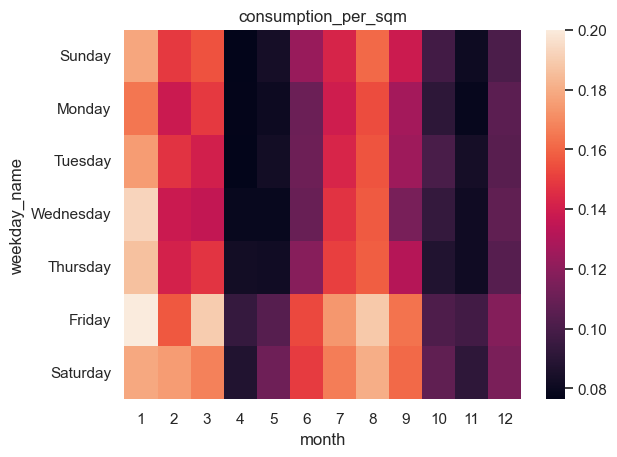

In [75]:
table = day_df.groupby(['weekday_name', 'month']).mean(numeric_only=True)['consumption_per_sqm'].reset_index().pivot(columns='month', index='weekday_name', values='consumption_per_sqm')
sns.heatmap(table).set(title='consumption_per_sqm')

<Axes: xlabel='count_reg', ylabel='area'>

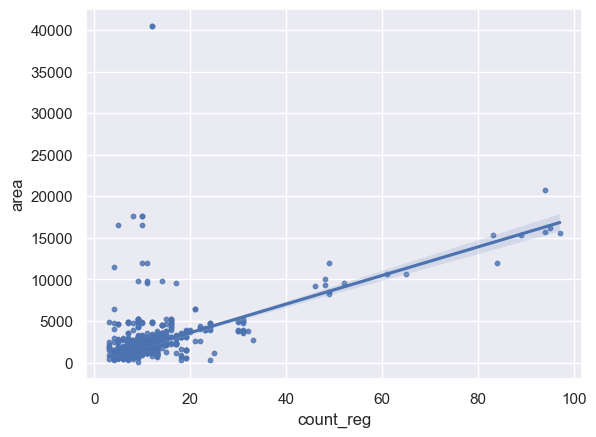

In [95]:
sns.regplot(x='count_reg', y='area', data=id_df[id_df.area > 0], scatter_kws={'s':10})

<Axes: xlabel='area', ylabel='consumption'>

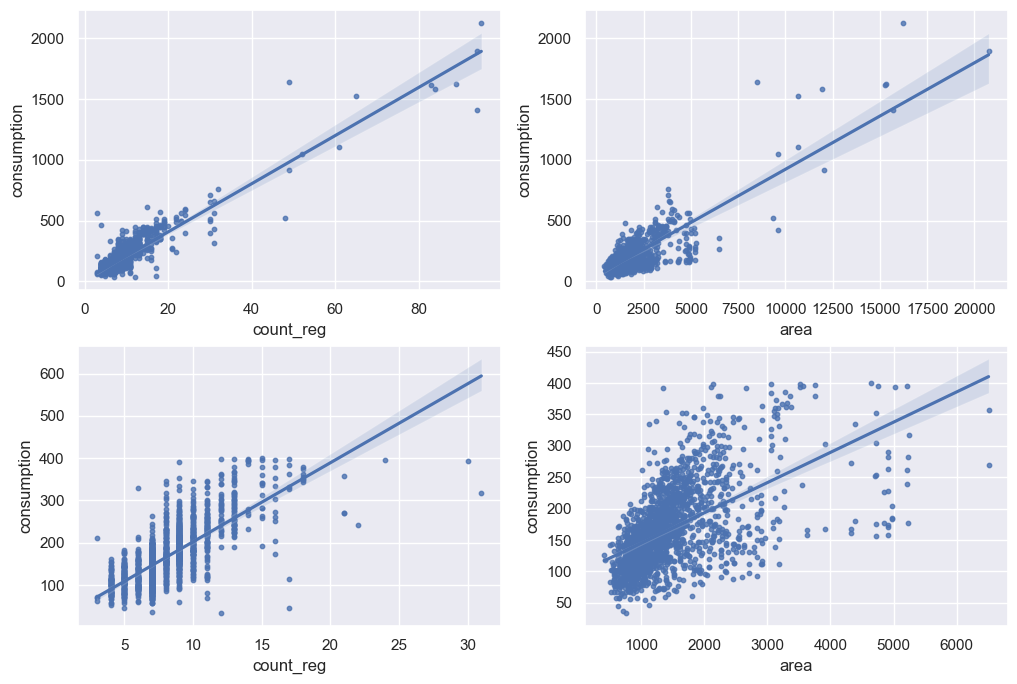

In [94]:
gr = day_df.groupby(['id']).mean(numeric_only=True)
_, ax = plt.subplots(2,2, figsize=(12,8))
sns.regplot(data=gr, x='count_reg', y='consumption', ax=ax[0][0], scatter_kws={'s':10})
sns.regplot(data=gr, x='area', y='consumption',ax=ax[0][1], scatter_kws={'s':10})
sns.regplot(data=gr[gr.consumption < 400], x='count_reg', y='consumption', ax=ax[1][0], scatter_kws={'s':10})
sns.regplot(data=gr[gr.consumption < 400], x='area', y='consumption',ax=ax[1][1], scatter_kws={'s':10})

# Consumption analysis

In [33]:
from collections import defaultdict
h_df = pd.DataFrame(hour_df)
day_mapping = {i: 'regular' for i in range(7)}
day_mapping[4] = 'friday'
day_mapping[5] = 'saturday'
h_df['day_type'] = hour_df.weekday.map(lambda x: day_mapping[x])
h_df.head(1)

,total,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,hour,consumption,ts,temperature,r_humidity,heat_index,area,consumption_per_sqm,day_type
872,1093.649048,702552305,49,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,0,30.026001,2022-01-01,10.716666,79.5,10.716667,12027.25,0.002496,saturday


In [25]:
w_df = pd.read_pickle('weather.pkl').reset_index(drop=True)
w_df = w_df[(w_df.city == MODIIN) & (w_df.ts.dt.year == 2022)]
w_df = w_df.groupby(w_df.ts.dt.day_of_year).mean()
w_df.head(1)

C:\Users\Chapanin\AppData\Local\Temp\ipykernel_7948\3504193848.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  w_df = w_df.groupby(w_df.ts.dt.day_of_year).mean()


,temperature,r_humidity,heat_index
ts,,,
1,9.863194,84.395833,9.863194


In [34]:
%%time
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_
agg_dict = h_df[['id', 'day_type', 'hour', 'consumption_per_sqm']].groupby(['id', 'day_type', 'hour']).agg(
    mean_consumption=('consumption_per_sqm', np.mean), 
    q_consumption=('consumption_per_sqm', percentile(0.2))).to_dict()

results = []
for x in h_df[['id', 'day_type', 'hour', 'consumption_per_sqm']].values:
    row = []
    for name in ['mean_consumption', 'q_consumption']:
        row.append(100*(x[3])/agg_dict[name][x[0], x[1], x[2]])
    results.append(row)
h_df[['normalized_consumption_sqm_day_hour', 'normalized_q_consumption_sqm_day_hour']] = results
h_df.head(1)

CPU times: total: 1min 8s
Wall time: 1min 9s


,total,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,...,consumption,ts,temperature,r_humidity,heat_index,area,consumption_per_sqm,day_type,normalized_consumption_sqm_day_hour,normalized_q_consumption_sqm_day_hour
872,1093.649048,702552305,49,מודיעין מכבים רעות,1,1,5,Saturday,1,52,...,30.026001,2022-01-01,10.716666,79.5,10.716667,12027.25,0.002496,saturday,92.310952,141.80063


In [35]:
%%time
agg_dict = h_df[['id','consumption_per_sqm']].groupby(['id']).agg(
    mean_consumption=('consumption_per_sqm', np.mean), 
    q_consumption=('consumption_per_sqm', percentile(0.2))).to_dict()
results = []
for x in h_df[['id', 'consumption_per_sqm']].values:
    row = []
    for name in ['mean_consumption', 'q_consumption']:
        row.append(100*(x[1])/agg_dict[name][x[0]])
    results.append(row)
h_df[['normalized_consumption_sqm', 'normalized_q_consumption_sqm']] = results
h_df.head(1)

CPU times: total: 27.7 s
Wall time: 28 s


,total,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,...,temperature,r_humidity,heat_index,area,consumption_per_sqm,day_type,normalized_consumption_sqm_day_hour,normalized_q_consumption_sqm_day_hour,normalized_consumption_sqm,normalized_q_consumption_sqm
872,1093.649048,702552305,49,מודיעין מכבים רעות,1,1,5,Saturday,1,52,...,10.716666,79.5,10.716667,12027.25,0.002496,saturday,92.310952,141.80063,99.104513,155.51067


In [36]:
h_df['r_heat_index'] = np.round(h_df.heat_index).astype('int')
warm_h_df = pd.DataFrame(h_df[(h_df.ts.dt.month >= 4) & (h_df.ts.dt.month <= 9)])

[Text(0.5, 1.0, 'MODIIN regular days April-Sept. Normalized consumption/sqm (w.r.t. 20th quantile for this building/day type/hour)')]

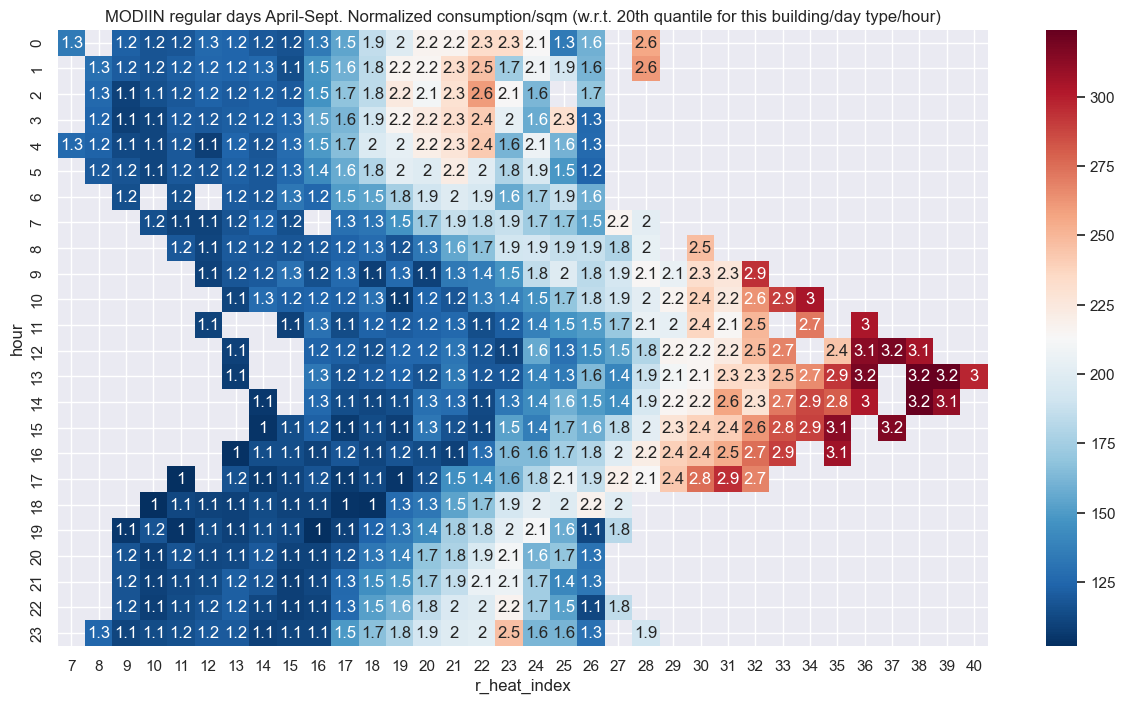

In [37]:
#gr = h_df[['day_type', 'hour', 'consumption', 'temperature', 'n_consumption']].groupby(['day_type', 'hour', 'consumption'
#for day_type in ['regular', 'friday', 'saturday'][:1]:
day_type = 'regular'
tmp = warm_h_df[['hour', 'normalized_q_consumption_sqm_day_hour', 'r_heat_index']]
table = tmp.groupby(['r_heat_index', 'hour']).mean().reset_index().pivot(columns='r_heat_index', index='hour', values='normalized_q_consumption_sqm_day_hour')
plt.figure(figsize=(15,8))
sns.heatmap(table, annot=np.round(table.values/100, 1), cmap='RdBu_r').set(title=f'MODIIN {day_type} days April-Sept. Normalized consumption/sqm (w.r.t. 20th quantile for this building/day type/hour)')

In [40]:
gr = warm_h_df.groupby(['ts', 'day_type', 'hour']).mean().reset_index()
d = w_df.to_dict()['heat_index']
temps = np.array([d[i] for i in range(1,366)])
gr['mean_hi'] = gr.ts.map(lambda x: temps[x.day_of_year - 1])
warm_h_df['mean_hi'] = h_df.ts.map(lambda x: temps[x.day_of_year - 1])
for ws in [3,5,7,10]:
    mean_temps = [temps[0]] + [temps[max(0, i-ws):i].mean() for i in range(1, len(temps))]
    gr[f'{ws}ma_hi'] = gr.ts.map(lambda x: mean_temps[x.day_of_year - 1])
    warm_h_df[f'{ws}ma_hi'] = h_df.ts.map(lambda x: mean_temps[x.day_of_year - 1])

gr.head(1)

C:\Users\Chapanin\AppData\Local\Temp\ipykernel_7948\1989924518.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gr = warm_h_df.groupby(['ts', 'day_type', 'hour']).mean().reset_index()


,ts,day_type,hour,total,id,count_reg,month,day,weekday,day_of_year,...,normalized_consumption_sqm_day_hour,normalized_q_consumption_sqm_day_hour,normalized_consumption_sqm,normalized_q_consumption_sqm,r_heat_index,mean_hi,3ma_hi,5ma_hi,7ma_hi,10ma_hi
0,2022-04-01,friday,0,139.664612,7.025881e+08,8.77635,4.0,1.0,4.0,91.0,...,75.804582,137.503838,73.970692,130.718537,20.0,23.404108,16.324074,14.089222,12.07881,10.191972


<Axes: xlabel='ts', ylabel='heat_index'>

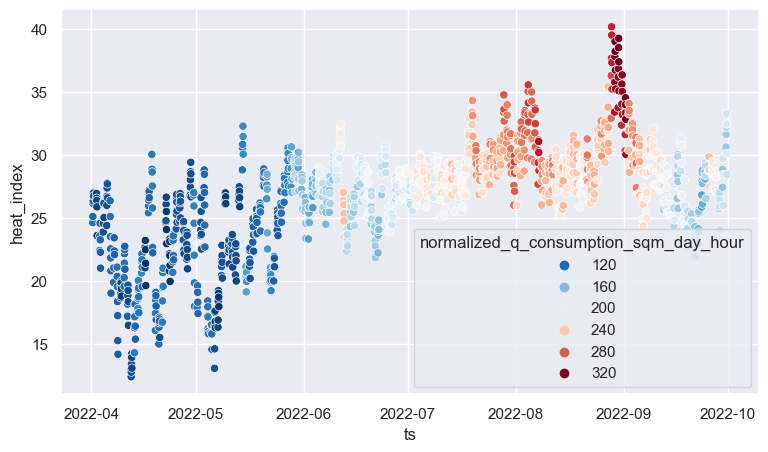

In [41]:
plt.figure(figsize=(9,5))
sns.scatterplot(data=gr[(gr.hour >= 10) & (gr.hour < 17)], x='ts', y='heat_index', hue='normalized_q_consumption_sqm_day_hour', palette='RdBu_r')

<Axes: xlabel='3ma_hi', ylabel='heat_index'>

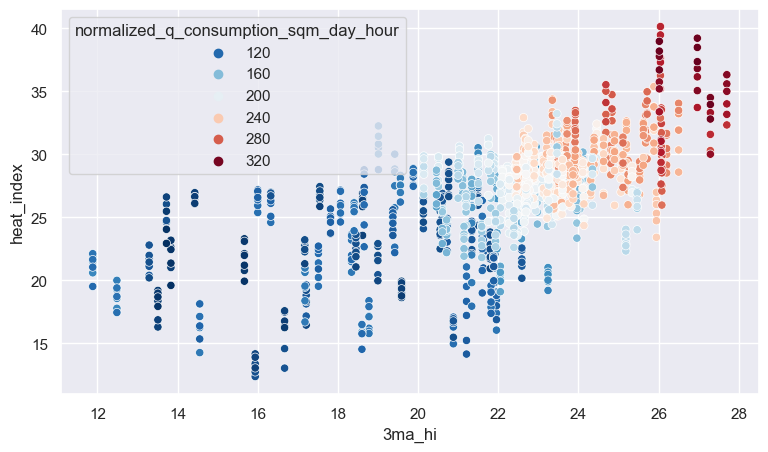

In [42]:
plt.figure(figsize=(9, 5))
sns.scatterplot(data=gr[(gr.hour >= 10) & (gr.hour < 17)], x='3ma_hi', y='heat_index', hue='normalized_q_consumption_sqm_day_hour', palette='RdBu_r')

In [59]:
warm_h_df.columns

Index(['total', 'id', 'count_reg', 'city', 'month', 'day', 'weekday',
       'weekday_name', 'day_of_year', 'week', 'year', 'hour', 'consumption',
       'ts', 'temperature', 'r_humidity', 'heat_index', 'area',
       'consumption_per_sqm', 'day_type',
       'normalized_consumption_sqm_day_hour',
       'normalized_q_consumption_sqm_day_hour', 'normalized_consumption_sqm',
       'normalized_q_consumption_sqm', 'r_heat_index', 'mean_hi', '3ma_hi',
       '5ma_hi', '7ma_hi', '10ma_hi'],
      dtype='object')

In [66]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
CUTOFF = 20
data = warm_h_df[(warm_h_df.hour > 16) & (warm_h_df.hour < 20)][['heat_index', '5ma_hi', '3ma_hi', '7ma_hi', 'normalized_q_consumption_sqm_day_hour', 'normalized_q_consumption_sqm', 'ts', 'area']]
data['shifted_hi'] = np.clip(data.heat_index - CUTOFF, 0, None)
data['shifted_5ma_hi'] = np.clip(data['5ma_hi'] - CUTOFF, 0, None)
data['shifted_3ma_hi'] = np.clip(data['3ma_hi'] - CUTOFF, 0, None)
data['shifted_7ma_hi'] = np.clip(data['7ma_hi'] - CUTOFF, 0, None)
data.head(1)

,heat_index,5ma_hi,3ma_hi,7ma_hi,normalized_q_consumption_sqm_day_hour,normalized_q_consumption_sqm,ts,area,shifted_hi,shifted_5ma_hi,shifted_3ma_hi,shifted_7ma_hi
28645400,25.733333,14.089222,16.324074,12.07881,96.621503,118.199699,2022-04-01 17:00:00,12027.25,5.733333,0.0,0.0,0.0


Feature importance: HEAT_INDEX - 5.603278880793964, 7DAY_AVG - 20.8907727957112, AREA - 0.0019935468808149268
R coef: 0.10307866930662168
MSE: 18802.063353909045


Text(0.5, 1.0, 'Real (red) vs predicted (blue) consumption change between 11 and 16')

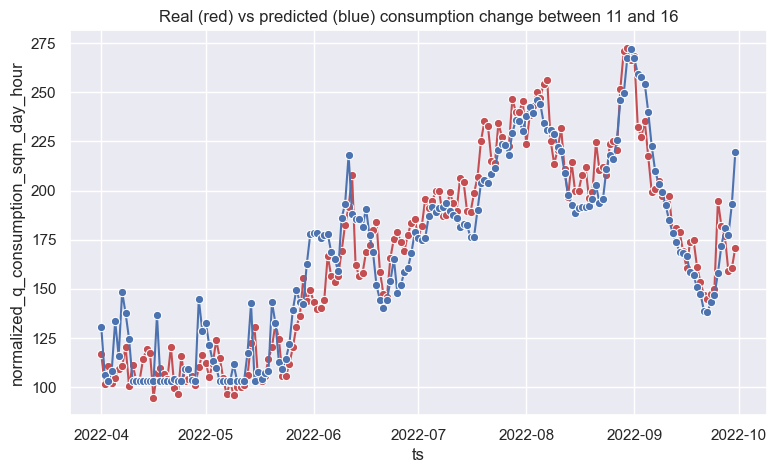

In [67]:
y = data.normalized_q_consumption_sqm_day_hour
X = data[['shifted_hi', 'shifted_7ma_hi', 'area']]
regr = linear_model.LinearRegression()
regr.fit(X, y)
preds = regr.predict(X)
data['preds'] = preds
print(f'Feature importance: HEAT_INDEX - {regr.coef_[0]}, 7DAY_AVG - {regr.coef_[1]}, AREA - {regr.coef_[2]}')
print(f'R coef: {regr.score(X, y)}')
print(f'MSE: {mean_squared_error(y, preds)}')
plt.figure(figsize=(9, 5))
gr = data.groupby(data.ts.dt.floor('D')).mean(numeric_only=True).reset_index()
sns.lineplot(data=gr, x='ts', y='normalized_q_consumption_sqm_day_hour', color='r', marker='o')
f = sns.lineplot(data=gr, x='ts', y='preds', color='b', marker='o')
f.set_title('Real (red) vs predicted (blue) consumption change between 11 and 16')

In [57]:
regr.intercept_

102.77340416458344

Text(0.5, 1.0, 'Real (red) vs predicted (blue) consumption change between 11 and 16 when trained till 1.08')

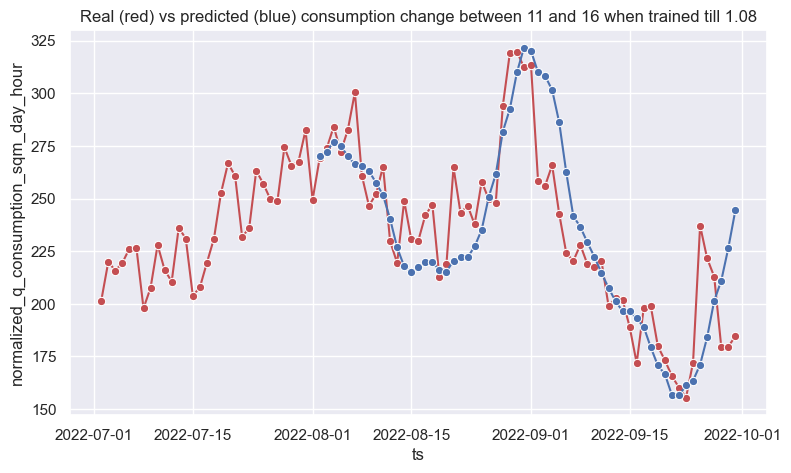

In [51]:
y = data[data.ts < pd.Timestamp('2022-08-01')].normalized_q_consumption_sqm_day_hour
X = data[data.ts < pd.Timestamp('2022-08-01')][['shifted_hi', 'shifted_7ma_hi']]
regr = linear_model.LinearRegression()
regr.fit(X, y)
data['preds'] = regr.predict(data[['shifted_hi', 'shifted_7ma_hi']])
plt.figure(figsize=(9, 5))
gr = data.groupby(data.ts.dt.floor('D')).mean(numeric_only=True).reset_index()
sns.lineplot(data=gr[gr.ts > pd.Timestamp('2022-07-01')], x='ts', y='normalized_q_consumption_sqm_day_hour', color='r', marker='o')
f = sns.lineplot(data=gr[gr.ts > pd.Timestamp('2022-08-01')], x='ts', y='preds', color='b', marker='o')
f.set_title('Real (red) vs predicted (blue) consumption change between 11 and 16 when trained till 1.08')